<a href="https://colab.research.google.com/github/jegot/frankAInstein/blob/main/working_10shotGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#code generation utilized Gemini for assitance.


from google.colab import files
from PIL import Image

# Upload up to 10 images
print("Please upload up to 10 images.")
uploaded = files.upload()


# Store the images in a dictionary
uploaded_images = {}
for filename in uploaded.keys():
    uploaded_images[filename] = Image.open(filename).convert("RGB")

print(f"Successfully uploaded {len(uploaded_images)} images.")

# The uploaded_images dictionary now contains the PIL Image objects
# with filenames as keys.

Please upload up to 10 images.


Saving 2.jpeg to 2.jpeg
Saving 3.jpeg to 3 (1).jpeg
Saving 5.jpeg to 5 (1).jpeg
Saving 6.jpeg to 6 (1).jpeg
Saving 7.jpeg to 7 (2).jpeg
Saving 9.jpeg to 9 (1).jpeg
Saving 10.jpeg to 10 (1).jpeg
Saving 11.jpeg to 11 (1).jpeg
Successfully uploaded 8 images.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Define a simple Generator model
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.img_shape = img_shape

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

# Define a simple Discriminator model
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(int(torch.prod(torch.tensor(img_shape))), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Custom Dataset for the uploaded images
class UploadedImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

# Hyperparameters
latent_dim = 100
lr = 0.0002
b1 = 0.5
b2 = 0.999
epochs = 1000
batch_size = len(processed_images) # Use all uploaded images as a single batch

img_shape = processed_images[0].shape # Get the shape from one of the processed images

# Initialize generator and discriminator
generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Dataset and DataLoader
dataset = UploadedImageDataset(processed_images)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
print("Starting GAN training...")
for epoch in range(epochs):
    for imgs in dataloader:

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1)
        fake = torch.zeros(imgs.size(0), 1)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample random noise
        z = torch.randn(imgs.size(0), latent_dim)

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real and fake images
        real_loss = adversarial_loss(discriminator(imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}] D loss: {d_loss.item():.6f}, G loss: {g_loss.item():.6f}")

print("Training finished.")

# Generate a new image
print("Generating a new image...")
generator.eval() # Set generator to evaluation mode
with torch.no_grad():
    z = torch.randn(1, latent_dim)
    generated_image_tensor = generator(z)

# Denormalize and convert to PIL Image
denormalize = transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2]) # Reverse the normalization
generated_image_tensor = denormalize(generated_image_tensor.squeeze(0))
generated_image_pil = transforms.ToPILImage()(generated_image_tensor)

print("Image generated.")

Starting GAN training...
Epoch [0/1000] D loss: 0.694628, G loss: 0.721862
Epoch [100/1000] D loss: 0.313752, G loss: 0.811250
Epoch [200/1000] D loss: 0.226166, G loss: 1.032561
Epoch [300/1000] D loss: 0.349775, G loss: 0.736748
Epoch [400/1000] D loss: 0.353102, G loss: 0.868932
Epoch [500/1000] D loss: 0.314801, G loss: 0.946791
Epoch [600/1000] D loss: 0.689522, G loss: 2.282212
Epoch [700/1000] D loss: 0.350813, G loss: 1.487395
Epoch [800/1000] D loss: 0.294951, G loss: 1.025592
Epoch [900/1000] D loss: 0.320202, G loss: 0.935302
Training finished.
Generating a new image...
Image generated.


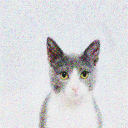

In [ ]:
from IPython.display import display

display(generated_image_pil)